### Preparing the Data

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
path=r'C:\Users\DELL\Downloads\data\names\*.txt'
def findFiles(path):return glob.glob(path)
print(findFiles(path))
import unicodedata
import string

all_letters = string.ascii_letters +'.,;' #获取A-Z大小写字符及“.,;”
n_letters=len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c)!='Mn'
        and c in all_letters
        )
print(unicodeToAscii('Ślusàrski'))

category_lines={}
all_categories=[]

def readLines(filename):
    lines=open(filename,encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(path):
    category=os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines=readLines(filename)
    category_lines[category]=lines
n_categories=len(all_categories)
print(category_lines['Italian'][:5])

['C:\\Users\\DELL\\Downloads\\data\\names\\Arabic.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\Chinese.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\Czech.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\Dutch.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\English.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\French.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\German.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\Greek.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\Irish.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\Italian.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\Japanese.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\Korean.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\Polish.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\Portuguese.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\Russian.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\Scottish.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\Spanish.txt', 'C:\\Users\\DELL\\Downloads\\data\\names\\Vietnamese.tx

### Turning Names into Tensors

In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]])
torch.Size([5, 1, 55])


In [37]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

tensor([    9,  9606, 25610,  ...,     9,     9,     9])


### Turning Names into Tensors

In [8]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.]])
torch.Size([5, 1, 55])


### Creating the Network

In [9]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [11]:
#使用简单文本，测试模型
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8634, -2.9208, -2.9325, -2.8143, -2.8139, -2.9034, -2.9146, -2.9824,
         -2.7852, -2.9411, -2.9637, -2.9338, -2.7963, -2.9411, -2.8555, -2.9263,
         -2.8669, -2.9015]], grad_fn=<LogSoftmaxBackward0>)


## Training

In [43]:
#从output中提取最大的类别及索引
def categoryFormOutput(output):
    top_n,top_i=output.topk(1)  #Tensor.topk to get the index of the greatest value
    category_i=top_i[0].item()
    return all_categories[category_i],category_i
print(categoryFromOutput(output))

('Vietnamese', 17)


In [44]:
import random
#从变量中随机输出一个索引
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]
#随机输出一个字符的类别、字符、类别索引，字符张量
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Korean / line = Song
category = Chinese / line = Xiang
category = Spanish / line = Holguin
category = Arabic / line = Naifeh
category = Italian / line = Negrini
category = French / line = Gagnon
category = Italian / line = Abrami
category = Korean / line = Shin
category = Polish / line = Sokolsky
category = Chinese / line = Xie


In [45]:
criterion=nn.NLLLoss()
learning_rate=0.005
def tain(category_tensor,line_tensor):
    hidden=rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

In [47]:
import time
import math
n_iters=100000
print_every=5000
plot_every=1000
current_loss=0
all_losses=[]
def timeSince(since):
    now=time.time()
    s=now-since
    m=math.floor(s/60)
    s-=m*60
    return '%dm %ds'  % (m,s)
start =time.time()

for iter in range(1,n_iters+1):
    category,line,category_tensor,line_tensor=randomTrainingExample()
    output,loss=tain(category_tensor,line_tensor)
    current_loss +=loss
    
    if iter % print_every==0:
        guess,guess_i=categoryFormOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100,
                                                timeSince(start), loss, line, guess, correct))
    if iter% plot_every==0:
        all_losses.append(current_loss/plot_every)
        current_loss=0

5000 5% (0m 5s) 2.2489 Carey / Portuguese ✗ (Irish)
10000 10% (0m 12s) 0.7440 Saeki / Japanese ✓
15000 15% (0m 18s) 1.4261 Vozab / Arabic ✗ (Czech)
20000 20% (0m 23s) 1.0370 Lieu / Vietnamese ✓
25000 25% (0m 29s) 2.0764 Thien / Vietnamese ✗ (Chinese)
30000 30% (0m 35s) 0.8313 Fabron / French ✓
35000 35% (0m 41s) 0.7178 Roosevelt / Dutch ✓
40000 40% (0m 47s) 0.3470 Finnegan / Irish ✓
45000 45% (0m 53s) 0.0618 Ieyasu / Japanese ✓
50000 50% (0m 59s) 1.2076 Pokorny / Polish ✓
55000 55% (1m 4s) 2.0903 Scott / English ✗ (Scottish)
60000 60% (1m 10s) 0.3808 Byon / Korean ✓
65000 65% (1m 16s) 0.0006 Chrysanthopoulos / Greek ✓
70000 70% (1m 22s) 0.5135 Rocha / Portuguese ✓
75000 75% (1m 28s) 4.4206 Desmond / Scottish ✗ (Irish)
80000 80% (1m 34s) 1.3594 Derrien / French ✗ (English)
85000 85% (1m 40s) 1.8859 Solberg / Dutch ✗ (German)
90000 90% (1m 46s) 0.5035 Yong / Chinese ✓
95000 95% (1m 51s) 0.6131 Mo / Korean ✓
100000 100% (1m 57s) 0.6418 Kui / Chinese ✓


### plotting the result

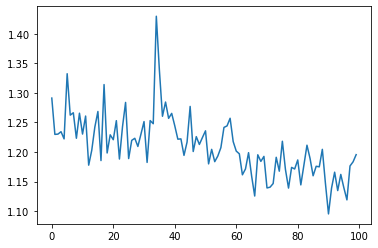

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.plot(all_losses)


C:\Users\DELL\AppData\Local\Temp/ipykernel_21624/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\DELL\AppData\Local\Temp/ipykernel_21624/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


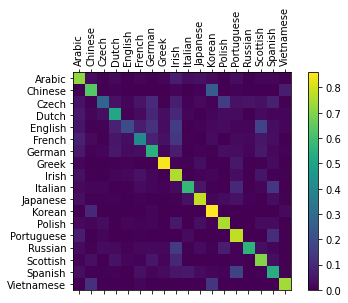

In [58]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick 强制设置X,Y轴上的每种语言都显示
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [65]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.78) Russian
(-1.23) Czech
(-2.19) Irish

> Jackson
(-0.35) Scottish
(-2.07) English
(-2.90) Czech

> Satoshi
(-0.40) Arabic
(-2.01) Japanese
(-2.74) Portuguese
